# Programming a feed-forward network with many hidden layers

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. The dataset (this is a shortened version of what you saw in the previous exercises)

The dataset contains 64x64 images of the signs used to represent the ten digits, 0-9. Indexes 204 to 408 of the dataset show the sign for zero and indexes 822 to 1027 show the sign for one.

In [26]:
X = np.load('digits_X.npy')
y = np.load('digits_y.npy')
print(X.shape)
print(y.shape)

(2062, 64, 64)
(2062, 10)


We only need the postures of zeros and ones for our purposes. Hence, start by gathering only the relevant X-variables:

In [27]:
X = np.concatenate((X[204:409], X[822:1028] ), axis=0)

In [28]:
X[822:1028]

array([], shape=(0, 64, 64), dtype=float32)

For the ys, we also only want the relevant ones. Moreover, we want to make sure that instead of a vector, we simply have 0 if the digit is zero and 1 if it is one:

In [4]:
z = np.zeros(409-204)
o = np.ones(1028-822)
y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)

With the `reshape`, we make sure that `y` is a vector with two dimensions:

In [5]:
print(X.shape)
print(y.shape)

(411, 64, 64)
(411, 1)


Next, we split the data into training and testing with 15% in the test set (you know the drill):

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=172)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(349, 64, 64)
(349, 1)
(62, 64, 64)
(62, 1)


Finally, we need to "flatten" the Xs.

In [7]:
X_train_flat = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_flat = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
print(X_train_flat.shape)
print(X_train_flat.shape)

(349, 4096)
(349, 4096)


## 2. Building the neural network

Let's go deeper. We are creating a model that uses multiple hidden layers. In particular, the `L-1` hidden layers will have sizes `hidden_layer_sizes` = $[n_1,n_2,...,n_{L-1}]$ (and the ReLU activation function). In addition, there is again an output layer with a single neuron performing the final binary classifcation (of course, using the logistic sigmoid function).

We use exactly the same approach as before, just that we need to "automate" our computations a bit more.

### Initialization

Keep in mind that each neuron in the hidden layer $l$ has weights for all $n_{l-1}$ incoming edges, as well as one bias term (in the case of layer 1, $n_0$ are the number of incoming edges from the input, so the number of features of `X`).

We will usually use dictionaries to store parameters when we have many. Note the naming convention for layers starting from 1 doesn't really fit well with the typical naming convention of Python. But we can make our life easier by treating the input layer as "Layer 0".

In [8]:
def initialize_parameters(seed=392,dimension=4096,hidden_layer_sizes=[3,3,3]):
    np.random.seed(seed)
    parameters = {}
    hidden_layer_sizes = [dimension] + hidden_layer_sizes
    
    for l in range(1,len(hidden_layer_sizes)+1):
        size_in = hidden_layer_sizes[l-1]
        if l < len(hidden_layer_sizes):
            size_out = hidden_layer_sizes[l]
            parameters['weights' + str(l)] = np.random.rand(size_in,size_out)*0.1 - 0.05    # Note the different initialization of parameters. This is to help learning along
        else:
            size_out = 1
            parameters['weights' + str(l)] = np.random.rand(size_in,size_out)*0.1 - 0.05    # Note the different initialization of parameters. This is to help learning along
        parameters['bias' + str(l)] = np.zeros((1,size_out))
    
    return parameters

A quick try:

In [9]:
parameters = initialize_parameters(seed=123,dimension=4096,hidden_layer_sizes=[3,3,3])
print(parameters["weights1"])
print(parameters["bias1"])
print(parameters["weights2"])
print(parameters["bias2"])
print(parameters["weights3"])
print(parameters["bias3"])
print(parameters["weights4"])
print(parameters["bias4"])

[[ 0.01964692 -0.02138607 -0.02731485]
 [ 0.00513148  0.0219469  -0.00768935]
 [ 0.04807642  0.01848297 -0.00190681]
 ...
 [ 0.02493274 -0.03018663  0.01595549]
 [-0.02067766 -0.02417833  0.01020214]
 [-0.03688084 -0.0183478   0.03154012]]
[[0. 0. 0.]]
[[-0.00393491  0.00078995 -0.00455399]
 [-0.02334688 -0.04890746 -0.03235216]
 [ 0.02281401 -0.00248282  0.03575233]]
[[0. 0. 0.]]
[[ 0.01298004  0.03058215  0.01388959]
 [-0.04397863  0.01331009 -0.04818968]
 [ 0.01143601 -0.00248161 -0.04888658]]
[[0. 0. 0.]]
[[0.01616097]
 [0.01043961]
 [0.00711826]]
[[0.]]


### Forward propagation

Forward propagation works the same as before, just over a few more layers. We will make use again of two helper functions to compute the ReLU activation (at the hidden layers) and the logistic sigmoid activation (at the output layer).

In [10]:
def relu(z):
    return np.maximum(0,z)

In [11]:
def sigma(z):
    return 1/(1 + np.exp(-z))

Next comes the actual forward propagation step. Remember that we need to compute:
1. For each neuron at the hidden layers $l=1,...,L-1$:
- $Z^{[l]}$ = the weighted sum of the inputs A^{[l-1]}, to which we add the bias (in the case of $Z^{[1]}$, we simply have $A^{[0]} = X$)
- $A^{[l]}$ = the actual activation: the neuron's activation function applied to $Z^{[l]}$
2. For the neuron at the output layer $L$:
- $Z^{[L]}$ = the weighted sum of the inputs $A^{[L-1]}$, to which we add the bias
- $A^{[L]}$ = the actual activation: the neuron's activation function applied to $Z^{[L]}$
3. The cost function, given $\hat{y} = A^{[L]}$: We will stick with what we saw before in binary classification, so $J=\frac{1}{n}\sum_{i=1}^n L^{(i)}$ with $L^{(i)} = -y^{(i)} \log \hat y^{(i)} - (1-y^{(i)}) (1-\log \hat y^{(i)})$

In [12]:
def forward_propagation(X,y,parameters,hidden_layer_sizes):
    cache = {}
    
    # Hidden layers
    current_A = X
    for l in range(1,len(hidden_layer_sizes)+1):
        current_Z = np.dot(current_A,parameters['weights'+str(l)]) + parameters['bias'+str(l)]
        
        current_A = relu(current_Z)
        cache['Z'+str(l)] = current_Z
        cache['A'+str(l)] = current_A

    # Output layer
    L = len(hidden_layer_sizes) + 1
    current_Z = np.dot(current_A,parameters['weights'+str(L)]) + parameters['bias'+str(L)]
    current_A = sigma(current_Z)
    cache['Z'+str(L)] = current_Z
    cache['A'+str(L)] = current_A
    
    # Compute the cost
    yHat = current_A 
    cost = np.sum(-y*np.log(yHat) - (1-y)*np.log(1-yHat))/X.shape[0] 

    return cost, cache

Note: we could technically read the layers out from the parameters, but we make things a bit simpler here and simply give the layers as an input

Try it out. If there are no mistake, the code below should print out
1. 0.6931471805599453
1. (349,3)
1. (349,3)
1. (349, 2)
1. (349, 2)
1. (349,1)
1. (349,1)

In [13]:
hidden_layer_sizes = [3,2]
parameters = initialize_parameters(seed=123,dimension=4096,hidden_layer_sizes=hidden_layer_sizes)
cost, cache = forward_propagation(X_train_flat,y_train,parameters,hidden_layer_sizes)
print(cost)
print(cache['Z1'].shape)
print(cache['A1'].shape)
print(cache['Z2'].shape)
print(cache['A2'].shape)
print(cache['Z3'].shape)
print(cache['A3'].shape)


0.6931471805599453
(349, 3)
(349, 3)
(349, 2)
(349, 2)
(349, 1)
(349, 1)


### Back-propagation

We move onto the second step of our update: finding the gradients. We do essentially the same as before, just that we keep going backward from layer $L-1$. The following generalizations of the derivatives may be helpful for the output layer (note - nothing changes here from before except the indexing):

- `dZ(L)` $= \nabla_{Z^{[L]}} J = \frac{1}{n}(A^{[L]} - y)$  (this should give you a $(n,1)$ matrix - why?)
- `dW(L)` $=\nabla_{W^{[L]}} J  = (A^{[L-1]})^T  (\nabla_{Z^{[L]}} J)$ (this should give you a $(n_{L-1},1)$ matrix - why?)
- `db(L)` $=\nabla_{b^{[L]}} J = \sum_{i=1}^n \frac{\partial J}{\partial z_1^{[L](i)}}$ (you are summing up over the entries of dZ(L))

And for the hidden layers $l=1,...,L-1$ (this is identical to the single hidden layer earlier, just that we generalize the indexes):

- `dZ(l)` $= \nabla_{Z^{[l]}} J = (\nabla_{Z^{[l+1]}} J) (W^{[l+1]})^T \circ E^{[l]}$. Here, $\circ$ is element-wise multiplication and $E^{[l]}$ is a matrix of the same dimensions as $Z^{[l]}$ that is 1 when the entry is positive and 0 otherwise (this should give you a $(n,n_l)$ matrix - why?)
- `dW(l)` $=\nabla_{W^{[l]}} J  = (A^{[l-1]})^T (\nabla_{Z^{[l]}} J)$ (this should give you a $(n_{l-1},n_l)$ matrix - why? Note that $A^{[0]} = X$, with $n_0 = m$)
- `db(l)` = $\left[ \nabla_{b^{[l]}_1} J, \nabla_{b^{[l]}_2} J,..., \nabla_{b^{[l]}_{n_l}} J \right] = \left[\sum_{i=1}^n \frac{\partial J}{\partial z_1^{[l](i)}}, \sum_{i=1}^n \frac{\partial J}{\partial z_2^{[l](i)}}, ..., \sum_{i=1}^n \frac{\partial J}{\partial z_{n_{l}}^{[l](i)}} \right]$ (you are summing up over **one** of the axes of dZ1 - be careful to choose the right one)

We can now define the back-propagation step, which returns the gradients. It might be helpful, instead of creating new variables `dZ` for each step, to simply overwrite the existing ones.

In [16]:
def back_propagation(X,y,parameters,cache,hidden_layer_sizes):
    grads = {}
    
    # Output layer
    L = len(hidden_layer_sizes) + 1
    dZ = (cache['A' + str(L)] - y)/X.shape[0]
    prev_A = cache['A' + str(L-1)]
    dW = np.dot(prev_A.T,dZ)
    db = np.sum(dZ,axis=0,keepdims=True)
    grads['weights' + str(L)] = dW
    grads['bias' + str(L)] = db
    
    # Hidden layers
    for l in range(L-1,0,-1):
        dZ = np.dot(dZ,parameters['weights' + str(l+1)].T)*np.where(cache['Z' + str(l)]>0,1,0)
        if l > 1:
            prev_A = cache['A' + str(l-1)]
        else:
            prev_A = X
        dW = np.dot(prev_A.T,dZ)
        db = np.sum(dZ,axis=0,keepdims=True)
        grads['weights' + str(l)] = dW
        grads['bias' + str(l)] = db
    
    return grads

If everything is programmed correctly, the below code should print out

1. -0.0014326647564469955
1. (4096, 3)
1. (1, 3)
1. (3, 2)
1. (1, 2)
1. (2, 1)
1. (1, 1)

In [18]:
hidden_layer_sizes = [4,3,2]
parameters = initialize_parameters(seed=456,dimension=4096,hidden_layer_sizes=hidden_layer_sizes)
cost, cache = forward_propagation(X_train_flat,y_train,parameters,hidden_layer_sizes)
grads = back_propagation(X_train_flat,y_train,parameters,cache,hidden_layer_sizes)
print(grads['bias3'][0,0])
print(grads['weights1'].shape)
print(grads['bias1'].shape)
print(grads['weights2'].shape)
print(grads['bias2'].shape)
print(grads['weights3'].shape)
print(grads['bias3'].shape)

8.061692347044935e-05
(4096, 4)
(1, 4)
(4, 3)
(1, 3)
(3, 2)
(1, 2)


### Putting it together: parameter updating and training

The parameter updating step is identical to before, only that we need to add the `hidden_layer_sizes` input

In [20]:
def parameter_update(X,y,parameters,learning_rate,hidden_layer_sizes):
    cost, cache = forward_propagation(X,y,parameters,hidden_layer_sizes)
    grads = back_propagation(X,y,parameters,cache,hidden_layer_sizes)
    for entry in parameters:
        parameters[entry] = parameters[entry] - learning_rate*grads[entry]
    return parameters, cost

We can now train our model, by running the parameter update multiple times. We will use 3 neurons at first hidden layer and 2 neurons at the second hidden layer. Notice the high number of iterations, that will be needed (but later on, we see how one can improve upon that).

Can you adjust the function below? Make sure to initialize the parameters with our custom-made function. Also, each time you run the parameter-update, store the resulting `cost` in a list `cost_list`. At the end, return the final `parameter` dictionary and the `cost_list`.

In [21]:
def model_training(X,y,hidden_layer_sizes=[3,2],learning_rate=0.005,iterations=20000,verbose=True):
    parameters = initialize_parameters(seed=np.random.randint(1),dimension=X.shape[1],hidden_layer_sizes=hidden_layer_sizes)
    cost_list = []
    for it in range(iterations):
        parameters,cost = parameter_update(X,y,parameters,learning_rate,hidden_layer_sizes)
        cost_list.append(cost)
        if verbose:
            print('Cost after iteration %i: %f' %(it,cost))
    return parameters, cost_list

Now, train the model and display the training loss. This might take a bit:

In [22]:
hidden_layer_sizes = [4,3,2]
parameters, cost_list = model_training(X_train_flat,y_train,hidden_layer_sizes)

Cost after iteration 0: 0.693147
Cost after iteration 1: 0.693147
Cost after iteration 2: 0.693147
Cost after iteration 3: 0.693147
Cost after iteration 4: 0.693147
Cost after iteration 5: 0.693147
Cost after iteration 6: 0.693147
Cost after iteration 7: 0.693147
Cost after iteration 8: 0.693147
Cost after iteration 9: 0.693147
Cost after iteration 10: 0.693147
Cost after iteration 11: 0.693147
Cost after iteration 12: 0.693147
Cost after iteration 13: 0.693147
Cost after iteration 14: 0.693147
Cost after iteration 15: 0.693147
Cost after iteration 16: 0.693147
Cost after iteration 17: 0.693147
Cost after iteration 18: 0.693147
Cost after iteration 19: 0.693147
Cost after iteration 20: 0.693147
Cost after iteration 21: 0.693147
Cost after iteration 22: 0.693147
Cost after iteration 23: 0.693147
Cost after iteration 24: 0.693147
Cost after iteration 25: 0.693147
Cost after iteration 26: 0.693147
Cost after iteration 27: 0.693147
Cost after iteration 28: 0.693147
Cost after iteration 29:

KeyboardInterrupt: 

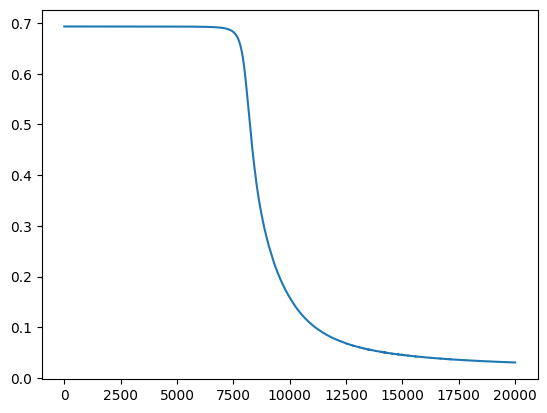

In [19]:
plt.plot(range(len(cost_list)),cost_list)
plt.show()

We can see already by looking at the report from the model training, and even more clearly in the graph, that we need quite some time to get to any sensible state with the model. If you play around with the initialization, you will notice that it is hard to even find value for which the model trains at all. This complexity in optimization is inherent to deep neural networks. Luckily, there are advanced optimization algorithms that speed things up (and increase our chances of even getting to a reasonable training result). We will learn about those in the next lectures.

### Making predictions

As before, we can now use our model to make predictions. The function is basically as before, just that we have to make sure to get the correct activation matrix from the cache (the one at the last layer).

In [20]:
def predict(X,parameters,hidden_layer_sizes=[3,2]):
    _, cache = forward_propagation(X,np.zeros((X.shape[0],1)),parameters,hidden_layer_sizes)
    yHat = cache['A' + str(len(hidden_layer_sizes)+1)]
    y_prediction = (yHat > 0.5) 
    return y_prediction

Let's see how well our predictions perform, both on the training set and the test set:

In [21]:
y_prediction_test = predict(X_test_flat,parameters,hidden_layer_sizes)
y_prediction_train = predict(X_train_flat,parameters,hidden_layer_sizes)

print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

train accuracy: 99.7134670487106 %
test accuracy: 93.54838709677419 %


A lot of training effort, and we actually did worse. With some regularization, we can probably do better, but we'll leave that for later.